<a href="https://colab.research.google.com/github/Haebuk/machine_learning_ex/blob/master/Apr_Kaggle_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2021 Apr Modeling
- [
N3. [TPS April 21] LightAutoML starter](https://www.kaggle.com/alexryzhkov/n3-tps-april-21-lightautoml-starter)
- [
TPS Apr 2021 pseudo labeling/voting ensemble](https://www.kaggle.com/hiro5299834/tps-apr-2021-pseudo-labeling-voting-ensemble/notebook?select=pseudo_label.csv )
- [Pseudolabelling - Tips and tricks](https://www.kaggle.com/c/tabular-playground-series-apr-2021/discussion/231738)


## Colab Softwrap

In [1]:
# colab softwrap
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

## Libraries

In [2]:
import pandas as pd
import numpy as np
import random
import time
import os

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
import torch
from sklearn.linear_model import LogisticRegression as lr
!pip install -q lightgbm==3.2.1
import lightgbm as lgb
!pip install -q catboost
import catboost as ctb
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz

import graphviz
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')


     |████████████████████████████████| 2.0MB 2.9MB/s 
     |████████████████████████████████| 67.3MB 70kB/s 


In [3]:
TARGET = 'Survived'

N_THREADS = 4
N_FOLDS = 10
TEST_SIZE = 0.2
TIMEOUT = 3 * 3600
N_ESTIMATORS = 1000
N_SPLITS = 10
SEED = 2021
EARLY_STOPPING_ROUNDS = 100 
VERBOSE = 100

In [4]:
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHEED'] = str(seed)
    np.random.seed(seed)

set_seed(SEED)

torch.set_num_threads(N_THREADS)

## Git Clone & Load Data

In [5]:
!git clone https://github.com/Haebuk/kuggle.git
PATH = '/content/kuggle/9,10주차/input/'
train_df = pd.read_csv(PATH+'train.csv')
test_df = pd.read_csv(PATH+'test.csv')
submission_df = pd.read_csv(PATH+'sample_submission.csv')

all_df = pd.concat([train_df, test_df]).reset_index(drop=True)

Cloning into 'kuggle'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 59 (delta 12), reused 44 (delta 7), pack-reused 0
Unpacking objects: 100% (59/59), done.


## Filling Missing Values

In [6]:
all_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
199995,199995,NaN,3,"Cash, Cheryle",female,27.0,0,0,7686,10.12,NaN,Q
199996,199996,NaN,1,"Brown, Howard",male,59.0,1,0,13004,68.31,NaN,S
199997,199997,NaN,3,"Lightfoot, Cameron",male,47.0,0,0,4383317,10.87,NaN,S
199998,199998,NaN,1,"Jacobsen, Margaret",female,49.0,1,2,PC 26988,29.68,B20828,C
199999,199999,NaN,1,"Fishback, Joanna",female,41.0,0,2,PC 41824,195.41,E13345,C


In [7]:
for col in all_df.columns:
    print(col, all_df[col].isnull().sum())

PassengerId 0
Survived 100000
Pclass 0
Name 0
Sex 0
Age 6779
SibSp 0
Parch 0
Ticket 9804
Fare 267
Cabin 138697
Embarked 527


In [8]:
def fill_nan_values(data):
    # 연령 결측값 -> 평균으로 대체
    data['Age'] = data['Age'].fillna(data['Age'].mean())
    # 선실 결측값 -> X로 대체 및 나머지는 첫글자로 대체
    data['Cabin'] = data['Cabin'].fillna('X').map(lambda x: x[0].strip())

    # 티켓 결측값 -> X로 대체 및 나머지는 첫 어절로 대체
    data['Ticket'] = data['Ticket'].fillna('X').\
    map(lambda x:str(x).split()[0] if len(str(x).split()) > 1 else 'X')

    # 요금 결측값 -> Pclass의 중위수로 대체 후 로그변환(정규화)
    fare_map = data[['Fare', 'Pclass']].dropna().groupby('Pclass').median().to_dict()
    data['Fare'] = data['Fare'].fillna(data['Pclass'].map(fare_map['Fare']))
    data['Fare'] = np.log1p(data['Fare'])

    # 탑승항구 결측값 -> X로 대체
    data['Embarked'] = data['Embarked'].fillna('X')

    # 성을 제외한 이름만 추출
    data['Name'] = data['Name'].map(lambda x: x.split(',')[0])
    
    return data

In [9]:
all_df = fill_nan_values(all_df)

## Encoding

In [10]:
label_cols = ['Name', 'Ticket', 'Sex']
onehot_cols = ['Cabin', 'Embarked']
numerical_cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [11]:
def label_encoder(c):
    le = LabelEncoder()
    return le.fit_transform(c)

scaler = StandardScaler()

onehot_encoded_df = pd.get_dummies(all_df[onehot_cols])
label_encoded_df = all_df[label_cols].apply(label_encoder)
numerical_df = pd.DataFrame(scaler.fit_transform(all_df[numerical_cols]), 
                            columns=numerical_cols)
target_df = all_df[TARGET]

all_df = pd.concat([numerical_df, label_encoded_df, onehot_encoded_df, target_df],\
                   axis=1)

In [12]:
# 피쳐 엔지니어링 후 다시 train/ test 분리
train_df2 = all_df[:train_df.shape[0]]
test_df2 = all_df[train_df.shape[0]:]

## Logistic Regression


In [13]:
feature_importances = pd.DataFrame()
X_test = test_df2.drop(TARGET, axis=1)
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

for fold, (train_idx, valid_idx) in enumerate(skf.split(train_df2, train_df2[TARGET])):
    print(f'===== FOLD {fold} =====')

    X_train, y_train = train_df2.iloc[train_idx].drop(TARGET, axis=1),\
    train_df.iloc[train_idx][TARGET]
    X_valid, y_valid = train_df2.iloc[valid_idx].drop(TARGET, axis=1),\
    train_df.iloc[valid_idx][TARGET]

    model = lr(max_iter=300, verbose=VERBOSE)
    model.fit(X_train, y_train)
    
    lr_val = model.predict(X_valid)
    lr_val = [1 if v >= 0.5 else 0 for v in lr_val]
    lr_preds = model.predict(X_test)

    
    # 확률이 0.5보다 크면 1, 작으면 0으로 분류
    acc_score = accuracy_score(y_valid, lr_val)
    print(f"===== ACCURACY SCORE {acc_score:.6f} =====\n")

===== FOLD 0 =====
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
===== ACCURACY SCORE 0.761900 =====

===== FOLD 1 =====
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
===== ACCURACY SCORE 0.773500 =====

===== FOLD 2 =====
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished
===== ACCURACY SCORE 0.769900 =====

===== FOLD 3 =====
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of  

In [14]:
submission_df_lr = pd.read_csv(PATH+'sample_submission.csv')
submission_df_lr['Survived'] = lr_preds
submission_df_lr.to_csv('lr_model.csv', index=False) # 0.78550 score

## LightGBM

In [15]:
params_lgb = {
    'metric': 'binary_logloss',
    'n_estimators': N_ESTIMATORS,
    'objective': 'binary',
    'random_state': SEED,
    'learning_rate': 0.01,
    'min_child_samples': 150,
    'reg_alpha': 3e-5,
    'reg_lambda': 9e-2,
    'num_leaves': 20,
    'max_depth': 16,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'subsample_freq': 2,
    'max_bin': 240,
}

In [16]:
feature_importances = pd.DataFrame()
X_test = test_df2.drop(TARGET, axis=1)
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

for fold, (train_idx, valid_idx) in enumerate(skf.split(train_df2, train_df2[TARGET])):
    print(f'===== FOLD {fold} =====')

    X_train, y_train = train_df2.iloc[train_idx].drop(TARGET, axis=1),\
    train_df.iloc[train_idx][TARGET]
    X_valid, y_valid = train_df2.iloc[valid_idx].drop(TARGET, axis=1),\
    train_df.iloc[valid_idx][TARGET]

    pre_model = lgb.LGBMRegressor(**params_lgb)
    pre_model.fit(
        X_train, y_train,
        eval_set = [(X_train, y_train), (X_valid, y_valid)],
        early_stopping_rounds = EARLY_STOPPING_ROUNDS,
        verbose = VERBOSE
    )

    params_lgb2 = params_lgb.copy()
    params_lgb2['learning_rate'] = params_lgb['learning_rate'] * 0.1
    model = lgb.LGBMRegressor(**params_lgb2)
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train),(X_valid, y_valid)],
        early_stopping_rounds=EARLY_STOPPING_ROUNDS,
        verbose=VERBOSE,
        init_model=pre_model
    )

    # feature importance
    fi_tmp = pd.DataFrame()
    fi_tmp['feature'] = model.feature_name_
    fi_tmp['importance'] = model.feature_importances_
    fi_tmp['fold'] = fold
    fi_tmp['seed'] = SEED
    feature_importances = feature_importances.append(fi_tmp)
    
    lgb_val = model.predict(X_valid)
    lgb_val = [1 if v >= 0.5 else 0 for v in lgb_val]
    lgb_preds = model.predict(X_test)

    
    # 확률이 0.5보다 크면 1, 작으면 0으로 분류
    acc_score = accuracy_score(y_valid, lgb_val)
    print(f"===== ACCURACY SCORE {acc_score:.6f} =====\n")

===== FOLD 0 =====
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.52195	valid_1's binary_logloss: 0.523998
[200]	training's binary_logloss: 0.484826	valid_1's binary_logloss: 0.488637
[300]	training's binary_logloss: 0.473859	valid_1's binary_logloss: 0.479154
[400]	training's binary_logloss: 0.469461	valid_1's binary_logloss: 0.475771
[500]	training's binary_logloss: 0.467025	valid_1's binary_logloss: 0.474104
[600]	training's binary_logloss: 0.465386	valid_1's binary_logloss: 0.473314
[700]	training's binary_logloss: 0.464096	valid_1's binary_logloss: 0.472792
[800]	training's binary_logloss: 0.463023	valid_1's binary_logloss: 0.472523
[900]	training's binary_logloss: 0.462084	valid_1's binary_logloss: 0.47237
[1000]	training's binary_logloss: 0.461183	valid_1's binary_logloss: 0.472227
Did not meet early stopping. Best iteration is:
[1000]	training's binary_logloss: 0.461183	valid_1's binary_logloss: 0.472227
Training until validatio

### Feature Importance

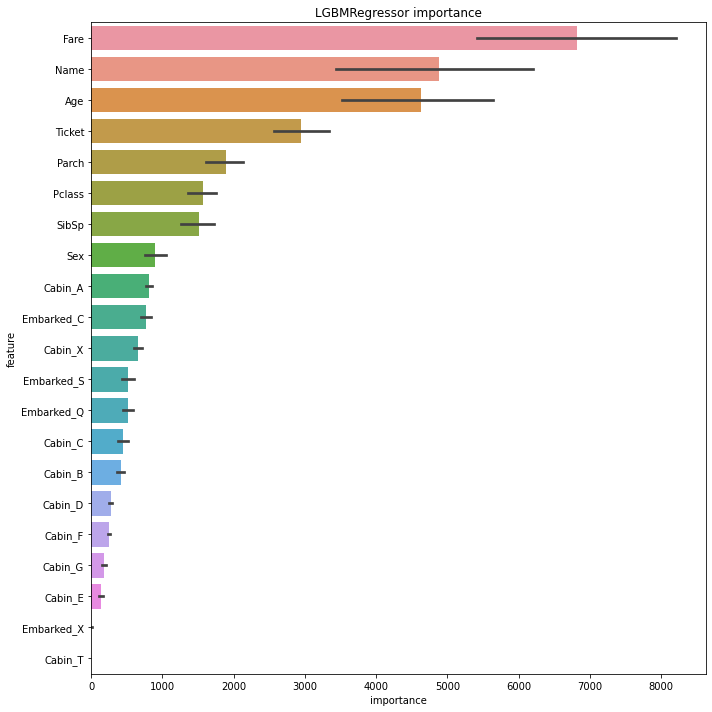

In [17]:
order = list(feature_importances.groupby('feature').mean().\
             sort_values('importance', ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x='importance', y='feature', data=feature_importances, order=order)
plt.title('{} importance'.format('LGBMRegressor'))
plt.tight_layout()

## CatBoost

In [18]:
params = {
    'bootstrap_type': 'Poisson',
    'loss_function': 'Logloss',
    'eval_metric': 'Logloss',
    'random_seed': SEED,
    'task_type': 'GPU',
    'max_depth': 8,
    'learning_rate': 0.01,
    'n_estimators': N_ESTIMATORS,
    'max_bin': 280,
    'min_data_in_leaf': 64,
    'l2_leaf_reg': 0.01,
    'subsample': 0.8
}

In [19]:
feature_importances = pd.DataFrame()

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

for fold, (train_idx, valid_idx) in enumerate(skf.split(train_df2, train_df2[TARGET])):
    print(f'===== FOLD {fold} =====')

    X_train, y_train = train_df2.iloc[train_idx].drop(TARGET, axis=1),\
    train_df.iloc[train_idx][TARGET]
    X_valid, y_valid = train_df2.iloc[valid_idx].drop(TARGET, axis=1),\
    train_df.iloc[valid_idx][TARGET]

    model = ctb.CatBoostClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        use_best_model = True,
        early_stopping_rounds=EARLY_STOPPING_ROUNDS,
        verbose=VERBOSE,
    )

    # feature importance
    fi_tmp = pd.DataFrame()
    fi_tmp['feature'] = X_test.columns.to_list()
    fi_tmp['importance'] = model.get_feature_importance()
    fi_tmp['fold'] = fold
    fi_tmp['seed'] = SEED
    feature_importances = feature_importances.append(fi_tmp)
    
    ctb_val = model.predict(X_valid)
    ctb_val = [1 if v >= 0.5 else 0 for v in ctb_val]
    ctb_preds = model.predict(X_test)
    
    # 확률이 0.5보다 크면 1, 작으면 0으로 분류
    acc_score = accuracy_score(y_valid, ctb_val)
    print(f"===== ACCURACY SCORE {acc_score:.6f} =====\n")

===== FOLD 0 =====
0:	learn: 0.6880903	test: 0.6881691	best: 0.6881691 (0)	total: 12.4ms	remaining: 12.4s
100:	learn: 0.4980883	test: 0.5026086	best: 0.5026086 (100)	total: 1.12s	remaining: 9.98s
200:	learn: 0.4738352	test: 0.4815454	best: 0.4815454 (200)	total: 2.21s	remaining: 8.81s
300:	learn: 0.4671796	test: 0.4774460	best: 0.4774460 (300)	total: 3.31s	remaining: 7.69s
400:	learn: 0.4635169	test: 0.4758125	best: 0.4758125 (400)	total: 4.42s	remaining: 6.6s
500:	learn: 0.4606931	test: 0.4749790	best: 0.4749790 (500)	total: 5.53s	remaining: 5.51s
600:	learn: 0.4582370	test: 0.4745422	best: 0.4745422 (600)	total: 6.62s	remaining: 4.39s
700:	learn: 0.4560694	test: 0.4743346	best: 0.4743346 (700)	total: 7.72s	remaining: 3.29s
800:	learn: 0.4538918	test: 0.4742854	best: 0.4742854 (800)	total: 8.81s	remaining: 2.19s
900:	learn: 0.4517679	test: 0.4742644	best: 0.4742418 (851)	total: 9.93s	remaining: 1.09s
999:	learn: 0.4498496	test: 0.4742635	best: 0.4741753 (985)	total: 11s	remaining: 0us

### Feature Importance

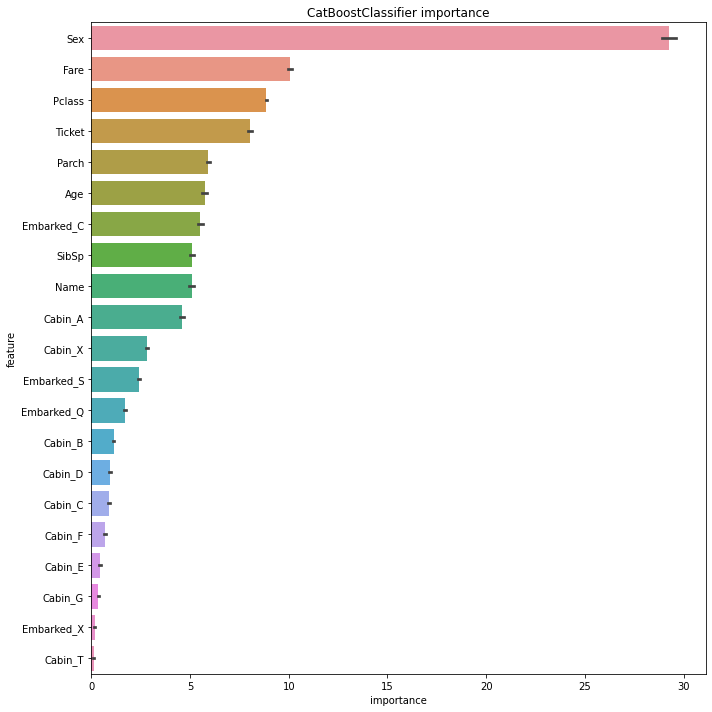

In [20]:
order = list(feature_importances.groupby("feature").mean()\
             .sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feature_importances, order=order)
plt.title("{} importance".format("CatBoostClassifier"))
plt.tight_layout()

## DecisionTreeModel

In [21]:
parameters = {
    'max_depth': np.arange(2, 5, dtype=int),
    'min_samples_leaf': np.arange(2, 5, dtype=int)
}

classifier = DecisionTreeClassifier(random_state=2021)

model = GridSearchCV(
    estimator = classifier,
    param_grid = parameters,
    scoring = 'accuracy',
    cv = 10,
    n_jobs = -1
)
model.fit(X_train, y_train)

best_parameters = model.best_params_
print(best_parameters)

{'max_depth': 4, 'min_samples_leaf': 2}


In [22]:
feature_importances = pd.DataFrame()

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

for fold, (train_idx, valid_idx) in enumerate(skf.split(train_df2, train_df2[TARGET])):
    print(f'===== FOLD {fold} =====')

    X_train, y_train = train_df2.iloc[train_idx].drop(TARGET, axis=1),\
    train_df.iloc[train_idx][TARGET]
    X_valid, y_valid = train_df2.iloc[valid_idx].drop(TARGET, axis=1),\
    train_df.iloc[valid_idx][TARGET]

    model = DecisionTreeClassifier(
        max_depth = best_parameters['max_depth'],
        min_samples_leaf = best_parameters['min_samples_leaf'],
        random_state = SEED
    )
    model.fit(X_train, y_train)
    
    dtm_val = model.predict(X_valid)
    dtm_val = [1 if v >= 0.5 else 0 for v in dtm_val]
    dtm_preds = model.predict(X_test)

    
    # 확률이 0.5보다 크면 1, 작으면 0으로 분류
    acc_score = accuracy_score(y_valid, dtm_val)
    print(f"===== ACCURACY SCORE {acc_score:.6f} =====\n")

===== FOLD 0 =====
===== ACCURACY SCORE 0.766600 =====

===== FOLD 1 =====
===== ACCURACY SCORE 0.783400 =====

===== FOLD 2 =====
===== ACCURACY SCORE 0.771000 =====

===== FOLD 3 =====
===== ACCURACY SCORE 0.770500 =====

===== FOLD 4 =====
===== ACCURACY SCORE 0.771200 =====

===== FOLD 5 =====
===== ACCURACY SCORE 0.772100 =====

===== FOLD 6 =====
===== ACCURACY SCORE 0.777900 =====

===== FOLD 7 =====
===== ACCURACY SCORE 0.781300 =====

===== FOLD 8 =====
===== ACCURACY SCORE 0.771300 =====

===== FOLD 9 =====
===== ACCURACY SCORE 0.772900 =====



### Plot Tree

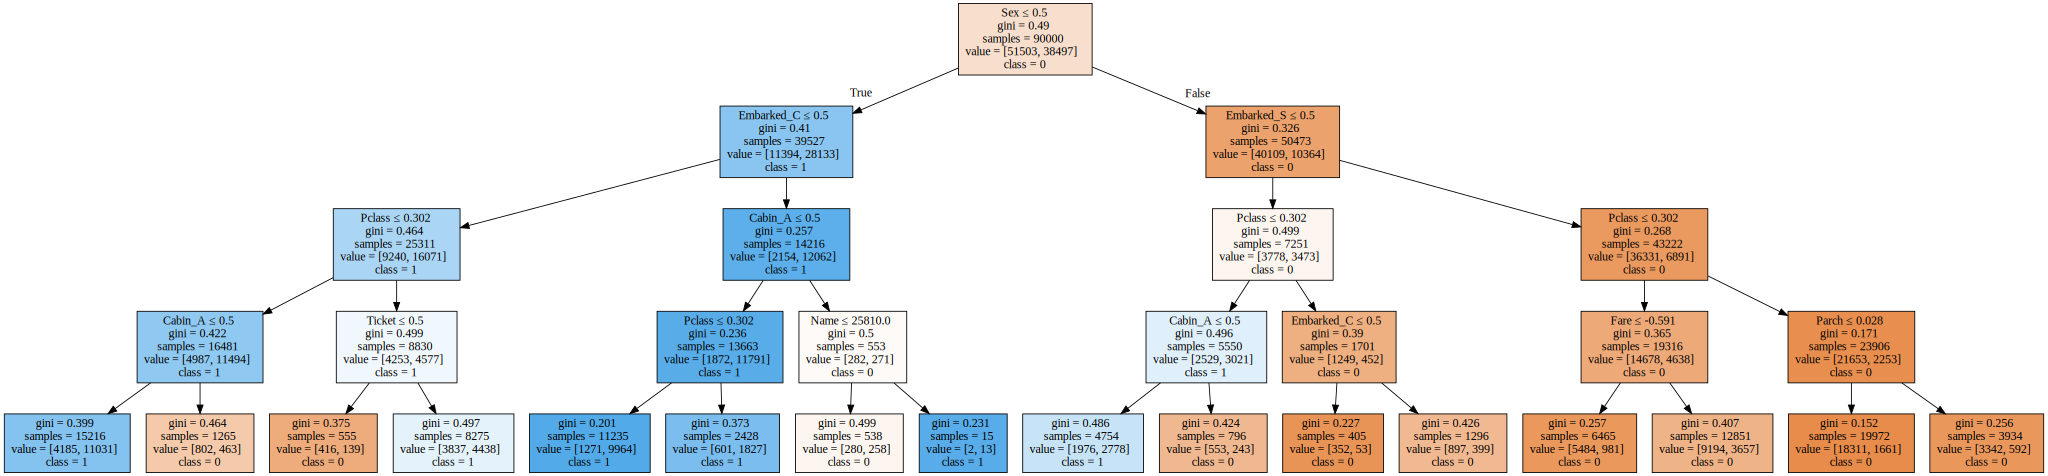

In [23]:
dot_data = export_graphviz(
    model,
    out_file = None,
    feature_names = X_train.columns,
    class_names = ['0', '1'],
    filled = True,
    rounded = False,
    special_characters = True,
    precision = 3
)
graph = graphviz.Source(dot_data)
graph

## Ensemble

In [24]:
submission_df['submit_lgb'] = [1 if pred >= 0.5 else 0 for pred in lgb_preds]
submission_df['submit_ctb'] = [1 if pred >= 0.5 else 0 for pred in ctb_preds]
submission_df['submit_dtm'] = [1 if pred >= 0.5 else 0 for pred in dtm_preds]

In [25]:
submission_df

,PassengerId,Survived,submit_lgb,submit_ctb,submit_dtm
0,100000,1,0,0,0
1,100001,1,1,1,1
2,100002,1,1,1,1
3,100003,1,0,0,0
4,100004,1,1,1,1
...,...,...,...,...,...
99995,199995,1,1,1,1
99996,199996,1,0,0,0
99997,199997,1,0,0,0
99998,199998,1,1,1,1


In [26]:
# 세 모델의 행 별로 생존자의 수를 더함
# 0은 모두 사망으로 예측, 1은 하나만, 2는 두 모델, 3은 세 모델이 모두 생존으로 예측
submission_df[[col for col in submission_df.columns if col.startswith('submit_')]]\
.sum(axis=1).value_counts()

0    63518
3    29313
1     4793
2     2376
dtype: int64

In [27]:
# 합이 2보다 크면 True -> int로 변환 (1)
submission_df[TARGET] = (submission_df[[col for col in submission_df.columns\
                                  if col.startswith('submit_')]].sum(axis=1) >= 2)\
                                  .astype(int)

In [28]:
submission_df.drop([col for col in submission_df.columns if col.startswith('submit_')],\
                 axis=1, inplace=True)

In [29]:
submission_df.to_csv('Apr_Ensemble.csv', index=False)

score: 0.80305, 369등

## Pytorch Deeplearning

In [32]:
# 데이터 다시 로드
train_df = pd.read_csv(PATH+'train.csv')
test_df = pd.read_csv(PATH+'test.csv')
submission_df = pd.read_csv(PATH+'sample_submission.csv')

all_df = pd.concat([train_df, test_df]).reset_index(drop=True)

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [33]:
# Preprocessing Again
y = train_df['Survived']
# 필요없거나 원핫인코딩으로 들어가는 피쳐는 단순하게 제거했음
X = fill_nan_values(all_df).drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived'], axis=1)

print(X.isnull().sum())

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


In [34]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,male,34.464565,2,0,3.337192,S
1,3,male,34.464565,0,0,2.663750,S
2,3,male,0.330000,1,2,4.280686,S
3,3,male,19.000000,0,0,2.641910,S
4,3,male,25.000000,0,0,2.170196,S


In [35]:
def label_encoder(c):
    le = LabelEncoder()
    return le.fit_transform(c)
scaler = StandardScaler()
# Age와 Fare에는 표준화를 적용
# Sex, Embarked, SibSp, Parch에는 라벨 인코딩
le = X[['Sex', 'Embarked', 'SibSp', 'Parch']].apply(label_encoder)
sc = pd.DataFrame(scaler.fit_transform(X[['Age', 'Fare']]), columns = ['Age', 'Fare'])

X2 = pd.concat([le, sc], axis=1)
X2

,Sex,Embarked,SibSp,Parch,Age,Fare
0,1,2,2,0,-8.614253e-16,0.134351
1,1,2,0,0,-8.614253e-16,-0.533837
2,1,2,1,2,-2.069149e+00,1.070483
3,1,2,0,0,-9.374220e-01,-0.555506
4,1,2,0,0,-5.737175e-01,-1.023540
...,...,...,...,...,...,...
199995,0,1,0,0,-4.524827e-01,-0.786852
199996,1,2,1,0,1.487275e+00,1.028715
199997,1,2,0,0,7.598657e-01,-0.722092
199998,0,0,1,2,8.811005e-01,0.220096


In [36]:
# 피쳐 엔지니어링 후 다시 train/ test 분리
train_df2 = X2[:train_df.shape[0]]
test_df2 = X2[train_df.shape[0]:]
print(train_df2.shape, test_df2.shape)

(100000, 6) (100000, 6)


In [38]:
# train / valid 데이터 7:3 비율로 분할
X_train, X_valid, y_train, y_valid = train_test_split(train_df2, y, test_size=0.3, random_state=42)

In [41]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [42]:
## train / valid data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

train_data = trainData(torch.tensor(X_train.to_numpy()), 
                       torch.tensor(y_train.to_numpy()))

valid_data = trainData(torch.tensor(X_valid.to_numpy()), 
                       torch.tensor(y_valid.to_numpy()))
# test data
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
       
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)

test_data = TestData(torch.tensor(test_df2.to_numpy()))

In [43]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=1, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [44]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 6
        self.layer_1 = nn.Linear(6, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [46]:
model = binaryClassification()
model.to(device)
print(model)
# 이진 분류 할떄 쓰는 loss
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=6, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [49]:
# train epoch 설정
epochs = EPOCHS

# loss 추적
valid_loss_min = np.Inf
val_loss = []
tn_loss = []
for epoch in range(1,epochs+1):

    # train/ validation loss 초기화
    train_loss = 0.0
    valid_loss = 0.0

    # 모델 훈련

    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):       
        

        data, target = data.to(device), target.to(device)
        # optimizer 초기화
        optimizer.zero_grad()
        # 계산
        output = model(data.float())
        # loss 계산
        loss = criterion(output, target.unsqueeze(1).type_as(output))
        # 그래디언트 계산
        loss.backward()
        # optimizer 업데이트
        optimizer.step()
        
        # train loss 업데이트
        train_loss += loss.item()*data.size(0)

    # 모델 검증

    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(valid_loader):
            
            data, target = data.to(device), target.to(device)
            # 계산
            output = model(data.float())
            # loss 계산
            loss = criterion(output, target.unsqueeze(1).type_as(output))
            # validation loss 업데이트
            valid_loss += loss.item()*data.size(0)
    
    # 평균 loss 계산
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    val_loss.append(valid_loss)
    tn_loss.append(train_loss)
    # loss statistics 출력
    print('Epoch: {} \t Training Loss: {:.3f} \t Validation Loss: {:.3f}'.format(epoch, train_loss, valid_loss))
    
    # validation loss 감소할 경우 모델 저장
    if valid_loss <= valid_loss_min:
        print("Validation loss decreased {:.4f}--->{:.4f}  Saving model...".format(valid_loss_min, valid_loss))
        # 현재 모델 저장
        torch.save(model.state_dict(), 'model_state.pt')
        valid_loss_min = valid_loss


Epoch: 1 	 Training Loss: 0.504 	 Validation Loss: 0.498
Validation loss decreased inf--->0.4982  Saving model...
Epoch: 2 	 Training Loss: 0.503 	 Validation Loss: 0.499
Epoch: 3 	 Training Loss: 0.503 	 Validation Loss: 0.497
Validation loss decreased 0.4982--->0.4969  Saving model...
Epoch: 4 	 Training Loss: 0.503 	 Validation Loss: 0.495
Validation loss decreased 0.4969--->0.4955  Saving model...
Epoch: 5 	 Training Loss: 0.502 	 Validation Loss: 0.496
Epoch: 6 	 Training Loss: 0.502 	 Validation Loss: 0.498
Epoch: 7 	 Training Loss: 0.501 	 Validation Loss: 0.496
Epoch: 8 	 Training Loss: 0.502 	 Validation Loss: 0.496
Epoch: 9 	 Training Loss: 0.501 	 Validation Loss: 0.496
Epoch: 10 	 Training Loss: 0.502 	 Validation Loss: 0.496
Epoch: 11 	 Training Loss: 0.501 	 Validation Loss: 0.496
Epoch: 12 	 Training Loss: 0.501 	 Validation Loss: 0.498
Epoch: 13 	 Training Loss: 0.501 	 Validation Loss: 0.497
Epoch: 14 	 Training Loss: 0.500 	 Validation Loss: 0.496
Epoch: 15 	 Training

In [50]:
# 학습한 모델 load
model.load_state_dict(torch.load('model_state.pt'))
model.eval()
model.cuda()

binaryClassification(
  (layer_1): Linear(in_features=6, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [80]:
# 모델 test 
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch.float())
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_pred_list = map(int, y_pred_list)

In [81]:
# 제출
id = submission_df['PassengerId']
sub = pd.concat([id, pd.Series(y_pred_list)], axis=1)
sub.columns = ['PassengerId', 'Survived']

In [82]:
sub

,PassengerId,Survived
0,100000,0
1,100001,1
2,100002,1
3,100003,0
4,100004,1
...,...,...
99995,199995,1
99996,199996,0
99997,199997,0
99998,199998,1


In [84]:
sub.to_csv('torch_submission.csv', index=False)

![image](https://user-images.githubusercontent.com/68543150/119361148-4caf7800-bce6-11eb-9e1d-0c622cd6d12c.png)


- 때로는 간단한게 최고